https://keras.io/examples/timeseries/timeseries_weather_forecasting/
    
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

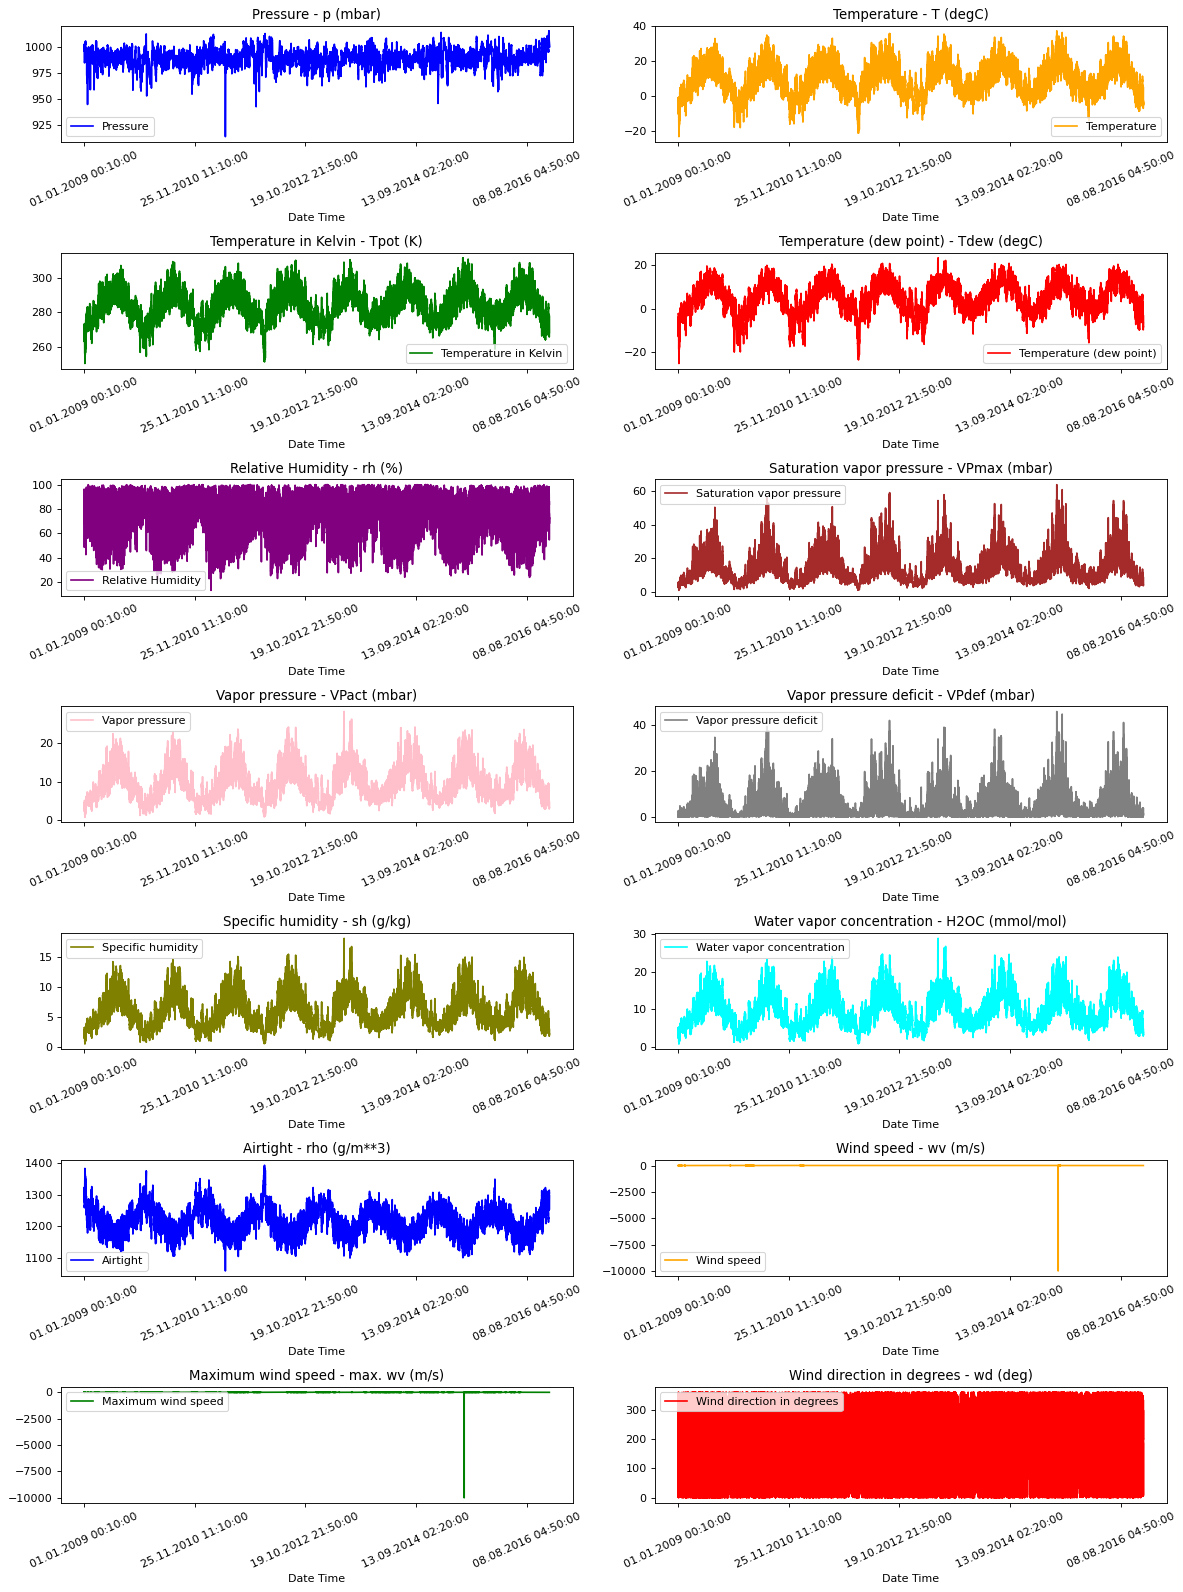

In [3]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

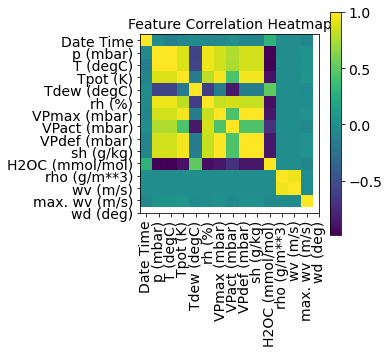

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [5]:
df

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420546  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420547  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420548  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420549  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420550  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.11          0.22       1.94   
1        93.40          3.23          3.02          0.21       1.89   
2        93.90          3.21          3.01          0.20       1.88   
3        94.20          3.26          3.07          0.19       1.92   
4        94.10          3.27          3.08          0.19       1.92   
...        ...           ...           ...           ...        ...   
420546   73.10          4.52          3.30          1.22       2.06   
420547   69.71          4.77          3.32          1.44       2.07   
420548   67.91          4.84          3.28          1.55       2.05   
420549   71.80          4.46          3.20          1.26       1.99   
420550   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0                  3.12       1307.75      1.03           1.75     152.3  
1                  3.03       1309.80      0.72           1.50     136.1  
2                  3.02       1310.24      0.19           0.63     171.6  
3                  3.08       1309.19      0.34           0.50     198.0  
4                  3.09       1309.00      0.32           0.63     214.3  
...                 ...           ...       ...            ...       ...  
420546             3.30       1292.98      0.67           1.52     240.0  
420547             3.32       1289.44      1.14           1.92     234.3  
420548             3.28       1288.39      1.08           2.00     215.2  
420549             3.20       1293.56      1.49           2.16     225.8  
420550             3.23       1296.38      1.23           1.96     184.9  

[420551 rows x 15 columns]

Preprocessing

In [6]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [7]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

train_data

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


0         1         2         3         4         5         6
0       0.955451 -2.000020 -1.319782 -0.788479 -1.500927  2.237658 -0.732997
1       0.961528 -2.045185 -1.332806 -0.790561 -1.519521  2.287838 -0.936002
2       0.956666 -2.056766 -1.335410 -0.792642 -1.523239  2.298608 -1.283076
3       0.954236 -2.033604 -1.328898 -0.794724 -1.508364  2.272906 -1.184847
4       0.954236 -2.028972 -1.327596 -0.794724 -1.508364  2.268256 -1.197944
...          ...       ...       ...       ...       ...       ...       ...
300688 -0.104339  0.853478  0.713250 -0.116113  1.429472 -0.878353 -0.890162
300689 -0.101908  0.881272  0.752322 -0.024521  1.392285 -0.900138 -0.477604
300690 -0.111631  0.902117  0.780974  0.021274  1.392285 -0.920454 -0.791934
300691 -0.117708  0.896327  0.771857  0.012948  1.388566 -0.916538 -0.791934
300692 -0.110416  0.863901  0.727576 -0.064072  1.396003 -0.887409 -0.831225

[300693 rows x 7 columns]

In [8]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[0]]

sequence_length = int(past / step)
sequence_length

y_train

0
792     1.102509
793     1.086710
794     1.069695
795     1.042957
796     1.030803
...          ...
301480  0.695365
301481  0.701442
301482  0.701442
301483  0.709949
301484  0.713595

[300693 rows x 1 columns]

In [9]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


## Validation dataset

In [10]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

inputs.shape[1]

Input shape: (256, 120, 7)
Target shape: (256, 1)


120

In [11]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1170/1172 [============================>.] - ETA: 0s - loss: 0.3098
Epoch 00001: val_loss improved from inf to 0.24259, saving model to model_checkpoint.h5
1172/1172 [==============================] - 14s 12ms/step - loss: 0.3094 - val_loss: 0.2426
Epoch 2/10
1169/1172 [============================>.] - ETA: 0s - loss: 0.2189
Epoch 00002: val_loss improved from 0.24259 to 0.20770, saving model to model_checkpoint.h5
1172/1172 [==============================] - 15s 13ms/step - loss: 0.2184 - val_loss: 0.2077
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1947
Epoch 00003: val_loss improved from 0.20770 to 0.19295, saving model to model_checkpoint.h5
1172/1172 [==============================] - 14s 12ms/step - loss: 0.1946 - val_loss: 0.1929
Epoch 4/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1832
Epoch 00004: val_loss improved from 0.19295 to 0.18071, saving model to model_checkpoint.h5
1172/1172 [==============================

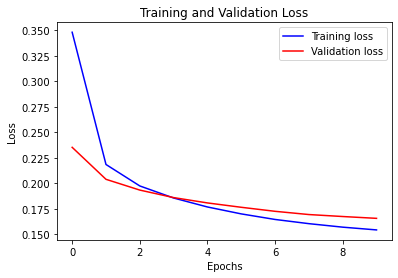

In [45]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

1 [0.71724149]
1 [0.530172]


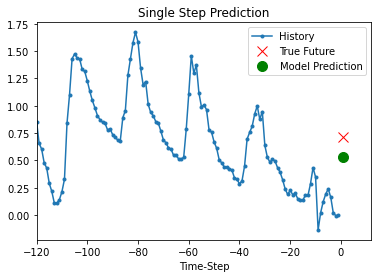

1 [0.63095126]
1 [-0.677327]


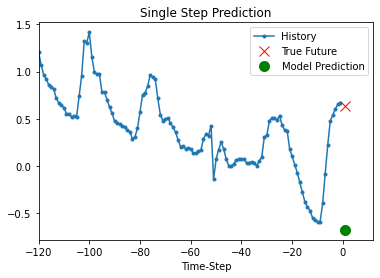

In [46]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta>0:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i>0:
            print(future, plot_data[i])
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )